### Анализ и прогнозирование временного ряда.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Загрузка данных

In [2]:
df = pd.read_excel('data/Lake.xls', index_col='Дата')
df.head()

,Станция,"Глубина станции, м","Прозр,м","Горизонт, м","Температура, оС","Раств кислород, мг/л",% насыщения
Дата,,,,,,,
1955-08-02,Станция-2,5.0,NaN,0.05,23.65,10.06,119.9
1955-08-02,Станция-2,5.0,NaN,3.00,19.00,5.27,57.2
1955-08-02,Станция-2,5.0,NaN,4.50,NaN,5.13,NaN
1955-08-18,Станция-2,5.5,NaN,0.05,22.30,9.96,115.5
1955-08-18,Станция-2,5.5,NaN,2.00,22.00,9.99,115.2


Будем исследовать растворимость кислорода на горизонте 3м за август месяц. Если за месяц имеется несколько наблюдений, возьмем среднее значение.

In [3]:
# Горизонт 3м и август месяц наблюдений растворимости кислорода
df = df[ (df['Горизонт, м'] == 3) & (df.index.month == 8) ]['Раств кислород, мг/л']

In [4]:
# df.resample(rule='AS-AUG').mean()

Будем исследовать наблюдения начиная с 1966 года.

In [5]:
df = df.resample(rule='AS-AUG').mean()['1966-08-01':]

In [6]:
df.index.rename('Data', inplace=True);
df.rename('Oxygen', inplace=True);

### Подгтовка данных

In [7]:
df.head()

Data
1966-08-01    8.373333
1967-08-01    8.720000
1968-08-01    8.856667
1969-08-01    8.925000
1970-08-01         NaN
Freq: AS-AUG, Name: Oxygen, dtype: float64

In [8]:
df.isnull().sum()

3

Видим, что имеются три пропуска. Заполним их средним арфемитическим соседних наблюдений.

In [9]:
for i in range(len(df)):
    if np.isnan(df.iloc[i]):
        df.iloc[i] = (df.iloc[i-1] + df.iloc[i+1]) / 2

### График временного ряда

In [10]:
def plot_attributes(ax, xlabel='', ylable='', title=''):
    ax.set_xlabel(xlabel, size = 15, weight='bold')
    ax.set_ylabel(ylable, size = 15, weight='bold')
    ax.set_title(title, size = 10, weight='bold')
    return ax

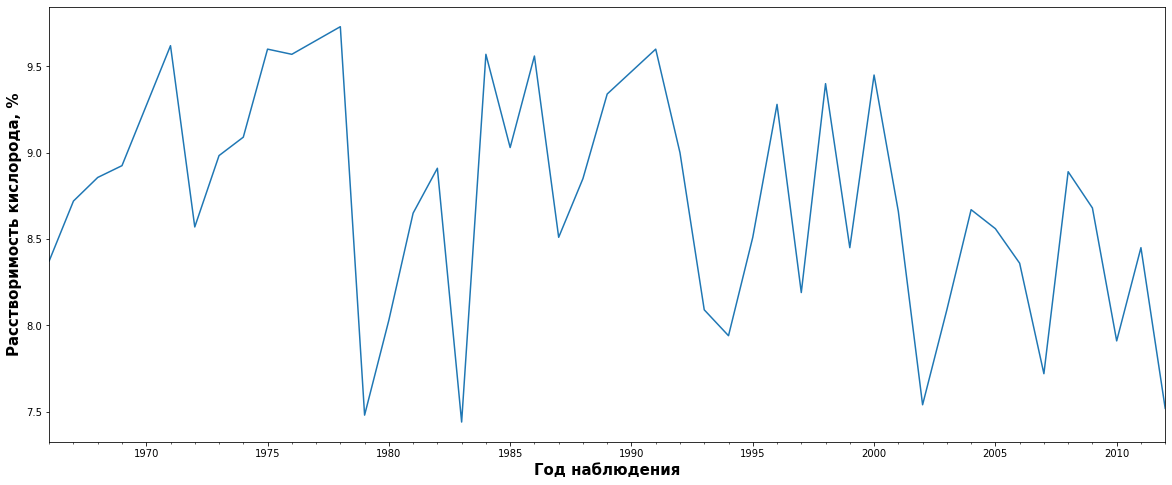

In [11]:
ax = df.plot(figsize=(20, 8));
plot_attributes(ax, 'Год наблюдения', 'Расстворимость кислорода, %');
plt.savefig('./img/исходныйряд.png')


### Анализ графика
- Так как мы используем наблюдения за август месяц с 1966 по 2012 года, то будем считать, что сезонность отсуствует.
- Со временем значения наблюдений падают, что может свидетельствовать о наличии нисходящего тренда, однако явно распознать его нельзя.
- Аномальные значения наблюдения при первом взгляде на график отсуствуют.

### Описательные характеристики

In [12]:
def describe(series):
    return pd.DataFrame(
        index=['observations','min-max','mean','variance','skewness','kurtosis'], 
        data=stats.describe(series), 
        columns=['satatistics'])

print(describe(df))
print(df.describe())
print(np.median(df))

               satatistics
observations            47
min-max       (7.44, 9.73)
mean              8.739571
variance          0.431117
skewness         -0.316759
kurtosis         -0.825824
count    47.000000
mean      8.739571
std       0.656595
min       7.440000
25%       8.366667
50%       8.720000
75%       9.310000
max       9.730000
Name: Oxygen, dtype: float64
8.719999999999999


- **Средняя растворимость кислорода**у озера Баторино в период с 1966 по 2012 год равна **8.74%.**

- **Коэффициент асимметрии** равен **-0.31**, что означает, что асимметрия умеренная. У нормального распределения коэффициент равен 0, следовательно, распределение несимметрично и немного скошено влево.

- **Коэффициент эксцесса** равен **-0.83**. У нормального распределения он имеет значение равное 0, из этого следует, что у нас пологий пик распределения по отношению к нормальному.

In [13]:
from scipy.stats import shapiro, kstest
from statsmodels.graphics.gofplots import qqplot
from sklearn import preprocessing

def shapiro_test(series):
    stat, p_val = shapiro(series)
    print('Shapiro-Wilk test:')
    print(f'p_value: {p_val}, statistics: {stat}')
    if(p_val > 0.05):
        print(f'assume a normal distribution')
    else:
        print(f'not assume a normal distribution')
        
def ks_test(series):
    #min_max_scaler = preprocessing.MinMaxScaler().fit_transform(np.array(seires))
    stat, p_val = kstest(preprocessing.MinMaxScaler().fit_transform(np.array(series).reshape(-1,1)), 'norm')
    print('Kolmogorov Smirnov test:')
    print(f'p_value: {p_val}, statistics: {stat}')
    if(p_val > 0.05):
        print(f'assume a normal distribution')
    else:
        print(f'not assume a normal distribution')
        
def check_normal(series):
    #Shapiro-Wilk test
    shapiro_test(series)
    
    print()
    
    #Kolmogorov Smirnov test:
    ks_test(series)
    
    fig, ax = plt.subplots(figsize=(12,6))
    
    #Histogram. Number of Bins is calculated by Sturges rule: bins= 1 + log2[N], N - size of series
    bins = int(3 + np.log2(series.size))
    series.plot.hist(bins=bins, edgecolor='k', density=True, ax=ax)
    s_min, s_max = np.min(series), np.max(series)
    s_mean, s_var = np.mean(series), np.var(series)
    
    mas = np.linspace(s_min, s_max, 100);
    ax.plot(mas, stats.norm.pdf(mas,loc=s_mean,scale=s_var), color='k');
    plot_attributes(ax, 'Расстворимость кислорода, %', '', 'Гистограмма');
    plt.savefig('./img/histogram.png')
    
    #QQ plot
    fig, ax = plt.subplots(figsize=(12,6))
    stats.probplot(series, plot=ax)
    plot_attributes(ax, 'Теоретические квантили', 'Выборочные квантили', 'Квантиль-квантиль график');
    plt.savefig('./img/qqplot.png')
    

### Проверка на нормальное распределение

Shapiro-Wilk test:
p_value: 0.04968912899494171, statistics: 0.9515230655670166
not assume a normal distribution

Kolmogorov Smirnov test:
p_value: 7.159630263352944e-38, statistics: 0.8413447460685429
not assume a normal distribution


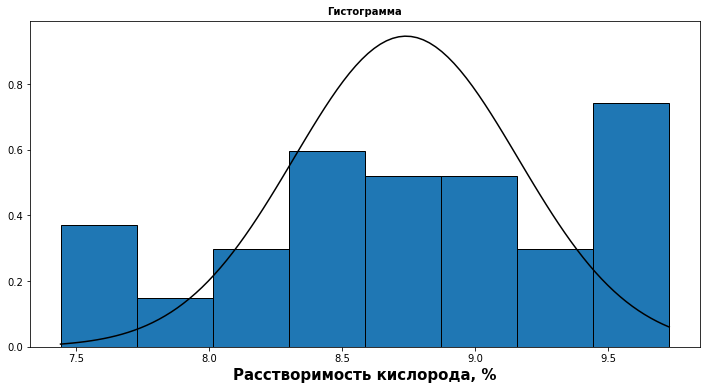

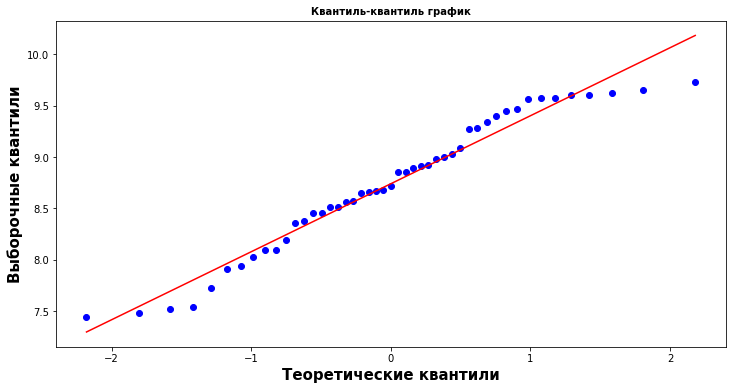

In [14]:
check_normal(df)

- Тест Шапиро-Уилка: p_value = 0.049 < 0.05, следовательно, гипотеза о нормальном рпспределении отвергается.
- Тест Колмагорова-Смирнова: p_value = 0.00 < 0.05, следовательно, гипотеза о нормальном рпспределении отвергается.
- Гистограмма скошена влево и имеет пологий пик. Данные не очень хорошо ложаться под график плотности нормального распределения.
- Точки на квантиль-квантиль графике выстраиваются в прямую линию, однако на концах присутсвуют отклонения.

**Вывод: исходный ряд не подчиняется закону нормального распределения**

In [15]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### Проверка на стационраность

In [16]:
adf_test(df)

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.013826
p-value                  0.000021
# lags used              0.000000
# observations          46.000000
critical value (1%)     -3.581258
critical value (5%)     -2.926785
critical value (10%)    -2.601541
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Тест Дики-Фуллера: p_value < 0.05, следовательно гипотеза о наличии единиченого корня отвергается и следовательно ряд стационарный.

### Фунция автокорреляций

<AxesSubplot:xlabel='Автокорреляция', ylabel='Лаг'>

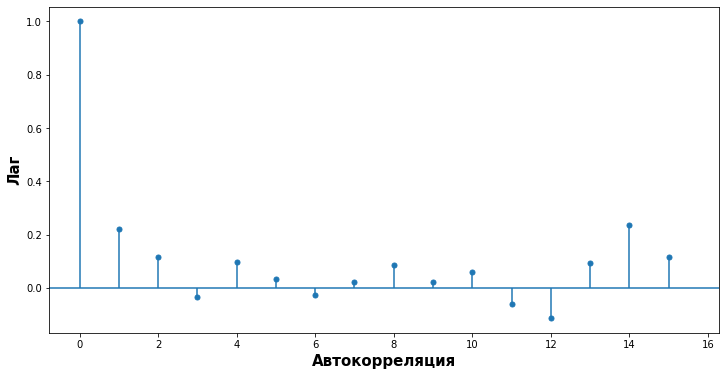

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(df, lags=15, ax=ax, alpha=1);
plt.savefig('./img/autocorreletion.png')
ax.set_title('')
ax.set_ylabel('Автокорреляция')
plot_attributes(ax, xlabel='Автокорреляция', ylable='Лаг')
#plot_pacf(df);

начиная с первого лага, значения функции автокорреляции можно считать равными нулю.

#### Тесты Льюнга-Бокса и Бокса-Пирсона

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [19]:
acorr_ljungbox(df, lags=5, boxpierce=True,return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.403042,0.121100,2.255917,0.133105
2,3.109719,0.211219,2.904906,0.233996
3,3.170744,0.366042,2.959704,0.397880
4,3.690356,0.449530,3.415690,0.490813
5,3.745030,0.586677,3.462553,0.629061


При проведении тестов, были получены статистики и p-значения для первых пяти лагов. Они показали, что нельзя отвергнуть гипотезу о том, что данные случайны(являются белым шумом).

### Проверим ряд на наличие тренда.
проведем два теста:
1. Тест Фостера-Стюарда
2. Критерий серий

In [20]:
# Foster-Stewart test
def FStest(series, alpha):
    n = series.size

    m = np.array([np.prod(series[:i] > series[i]) for i in range(1, n)])
    l = np.array([np.prod(series[:i] < series[i]) for i in range(1, n)])
    
    D = (m - l).sum()
    R = (m + l).sum()

    nu = sum([2/i for i in range(2, n)])
    s_D = np.sqrt(2*np.log(n)-0.8456)
    s_R = np.sqrt(2*np.log(n)-3.4253)
    
    t_D = np.abs(D/s_D)
    t_S = np.abs((R-nu)/s_R)
    t_critical = stats.t.ppf(q=1-alpha/2,df=n-2)
    print('Foster-Stewart test: ')
    if t_D > t_critical or t_S > t_critical:
        print('Reject the H0 hypotysis, series contains trend')
    else:
        print('Faile to reject Ho, series does not contains trend')
        
    print(f'Statistic for the trend in mean: {t_S}, p-value: {2*stats.t.sf(t_S, df=n-2)}')
    print(f'Statistic for the trend in variance: {t_D}, p-value: {2*stats.t.sf(t_D, df=n-2)}')
    print(f'Critical value: {t_critical}')

In [21]:
# Inversion criterion
def INV_test(series, alpha):
    n = series.size
    I = [
        sum([1 if series[t] > series[k] else 0 for k in range(t+1, n)]) 
        for t in range(n-1)
    ]
    mean = n*(n-1)/4
    sd = np.sqrt(n*(2*n+5)*(n-1)/72)
    statistic = np.abs((sum(I) - mean) / sd)
    p_value = 2 * stats.norm.sf(statistic)
    return dict(statistic=statistic, p_value=p_value)
    

In [22]:
FStest(df, 0.05)
#INV_test(df, 0.05)

Foster-Stewart test: 
Faile to reject Ho, series does not contains trend
Statistic for the trend in mean: 1.0478908205083783, p-value: 0.30028471528047557
Statistic for the trend in variance: 1.909747411679221, p-value: 0.06255269637086287
Critical value: 2.0141033848332923


Так как делал функции для вычисления статистики этих двух тестов сам, не могу быть уверен в их правильности на 100 процентов.
- критерий Фостера-Стюарта не отвергает гипотезу об отсутствии тренда.
- критерий инверсий отвергает гипотезу об отсутствии тренда.

### Оценка семивариограммы

In [23]:
def variogram(series, lag):
    fig, ax = plt.subplots(figsize=(12,6))
    a = np.array([np.var(series - series.shift(i)) / 2 for i in range(lag)])
    plt.plot(np.arange(0,lag), a);
    plt.plot([0, lag], [np.var(series), np.var(series)]);
    plot_attributes(ax, 'lag', 'Variance', 'Variogran');
    return ax

In [24]:
import pykrige as pk

In [25]:
variogram_models = pd.DataFrame()

In [26]:
var_size = 23

In [27]:
variogram_models['Variogram'] = np.array([np.var(df - df.shift(i)) / 2 for i in range(var_size)])

**Гауссовская модель**

In [28]:
variogram_models['Gaussian Model (0.431117, 1.5, 0)'] = [pk.variogram_models.gaussian_variogram_model([0.431117, 1.5, 0], i) for i in range(var_size)]

**Экспоненциальная 1 без самородка**

In [29]:
variogram_models['Exponential Model (0.431117, 2.3, 0)'] = [pk.variogram_models.exponential_variogram_model([0.431117, 2.3, 0], i) for i in range(var_size)]

**Экспоненциальная 2 без самородка**

In [30]:
variogram_models['Exponential Model (0.431117, 2.42, 0)'] = [pk.variogram_models.exponential_variogram_model([0.431117, 2.42, 0], i) for i in range(var_size)]

**Экспоненциальная 3 с самородком**

In [31]:
variogram_models['Exp model with sill (0.163, 7, 0.268)'] = [pk.variogram_models.exponential_variogram_model([0.163, 7, 0.268], i) for i in range(var_size)]

**Линейная 1 без самородка**

In [32]:
variogram_models['Linear model (0.431117, 0)'] = pd.Series(
    [pk.variogram_models.linear_variogram_model([0.431117, 0], i) if i < 2
     else pk.variogram_models.linear_variogram_model([0.431117, 0], 1) for i in range(var_size)])

**Линейная 2 с самородком**

In [33]:
variogram_models['Linear model (0.05435, 0.268064)'] = pd.Series(
    [pk.variogram_models.linear_variogram_model([0.05435, 0.268064], i)  if i < 4 
     else pk.variogram_models.linear_variogram_model([0.05435, 0.268064], 3)
     for i in range(var_size)]
)

In [34]:
from sklearn.metrics import mean_absolute_error
def var_exp(params, size):
    return [pk.variogram_models.exponential_variogram_model(params, i) for i in range(1, size)]
def var_gauss(params, size):
    return [pk.variogram_models.gaussian_variogram_model(params, i) for i in range(1, size)]
def var_linear(params, size):
    return [pk.variogram_models.linear_variogram_model(params, i) for i in range(1, size)]

def grid_search(model, m, data_variogram, size):
    params = [0, 0]
    error = np.inf
    
    psills = m[0]
    ranges = m[1]
    sills = m[2]
    
    for psill in psills:
        for r in ranges:
            for sill in sills:
                m = [psill, r, sill]
                if error > mean_absolute_error(data_variogram[1:], model(m, size)[1:]):
                    error = mean_absolute_error(data_variogram[1:], model(m, size)[1:])
                    params = [m[0], m[1], m[2]]
    return params

In [35]:
#grid_search(var_exp, [[0.163], np.linspace(3, 10, 700), np.linspace(0.24, 0.3, 100)] , variogram_models['Variogram'].iloc[1:3], 3)

In [36]:
def models_view(variogram_models):
    for i in variogram_models.columns:
        if i != 'Variogram':
            fig, ax = plt.subplots(figsize=(12,6))
            plot_attributes(variogram_models[[i,'Variogram']].plot(ax=ax), xlabel='lag', ylable='variance', title=i)
            #plot_attributes(variogram_models[[i,'Variogram']].plot(figsize=(12,6)), 
                            #xlabel='lag', ylable='variance', title=i).get_figure().savefig('photos/' + i + '.png')

<AxesSubplot:xlabel='Семивариограмма', ylabel='Лаг'>

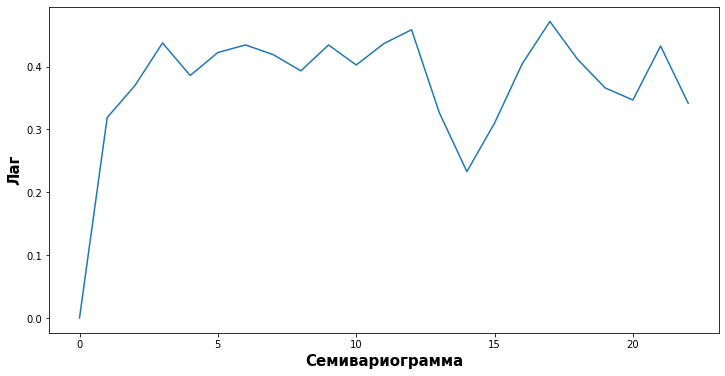

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
variogram_models['Variogram'].plot(ax=ax)
plot_attributes(ax, xlabel='Семивариограмма', ylable='Лаг')

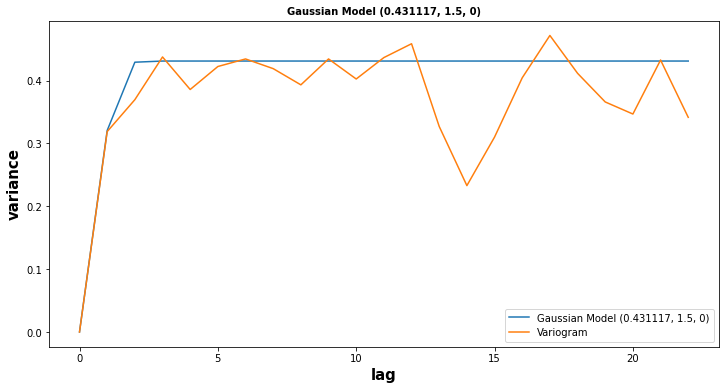

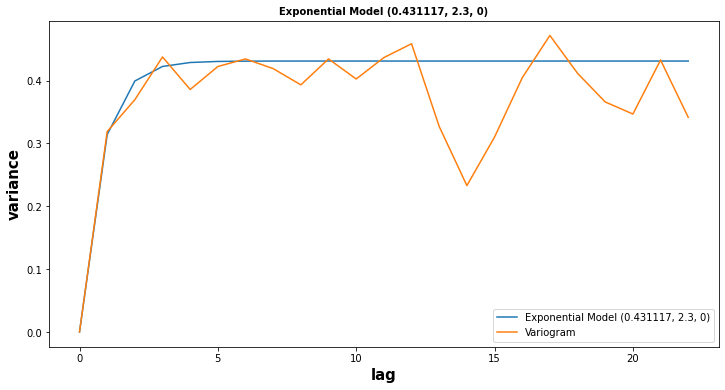

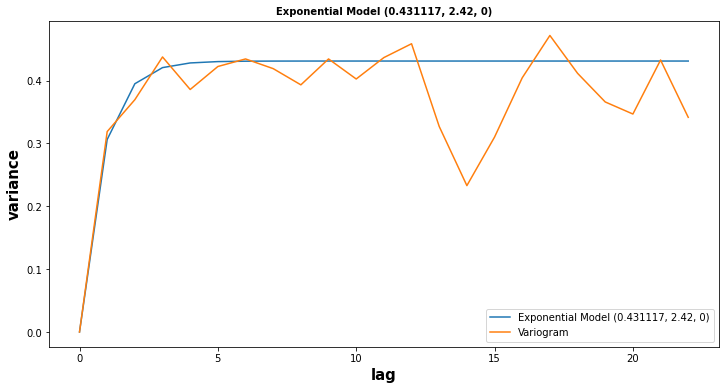

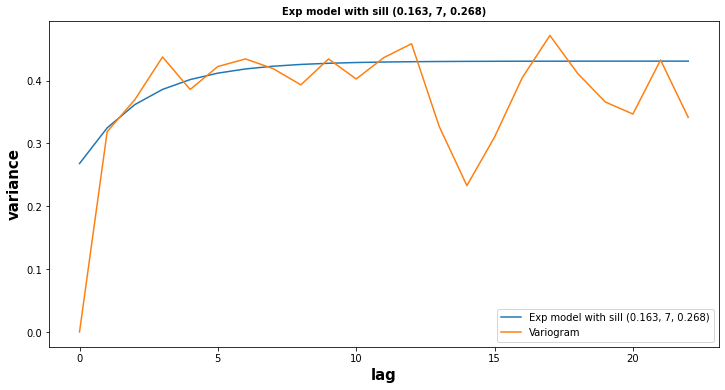

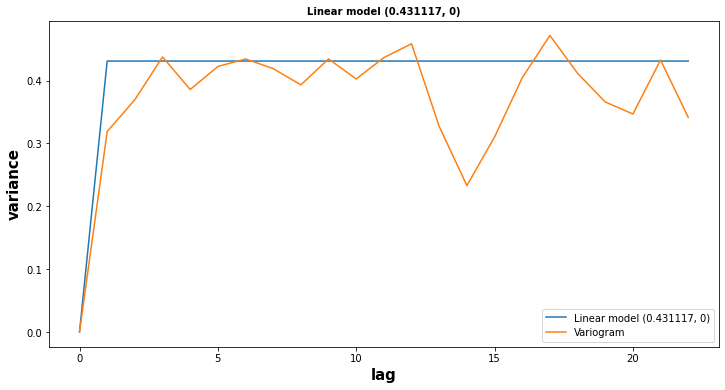

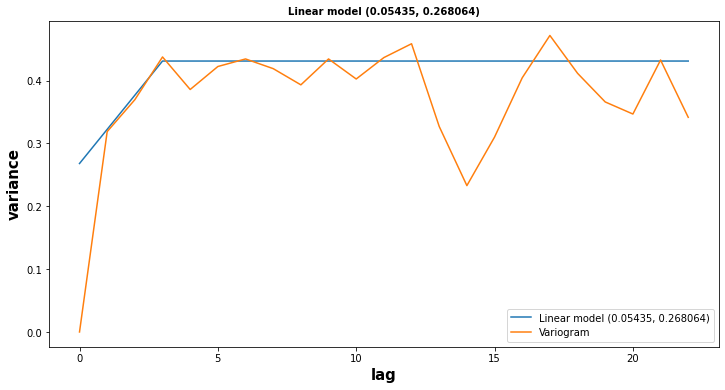

In [38]:
models_view(variogram_models)

In [39]:
from pykrige import OrdinaryKriging
#plt.style.use("ggplot")

**Подготовка данных**

In [40]:
X_train, y_train = np.arange(1, 41), df.iloc[:40].to_numpy()
X_test, y_test = np.arange(41, 48), df.iloc[40:].to_numpy()

In [41]:
kriging_models = [
    [X_train, y_train, X_test, y_test,
     'gaussian', {'sill': 0.431117, 'range': 1.5, 'nugget': 0}],
    [X_train, y_train, X_test, y_test,
       'exponential', {'sill': 0.431117, 'range': 2.3, 'nugget': 0}],
    [X_train, y_train, X_test, y_test,
       'exponential', {'sill': 0.431117, 'range': 2.42, 'nugget': 0}],
    [X_train, y_train, X_test, y_test,
       'exponential', {'psill': 0.163, 'range': 7, 'nugget': 0.268}],
    [X_train, y_train, X_test, y_test,
       'linear', {'slope': 0.431117, 'nugget': 0}],
    [X_train, y_train, X_test, y_test,
       'linear', {'slope': 0.05435, 'nugget': 0.268064}]
]

In [42]:
def errors_table(name, y_test, y_pred):
    table = pd.DataFrame(columns=[name], index=['E','std','MAE', 'MSE'])
    residuals = y_test - y_pred
    
    table[name] = [round(np.mean(residuals), 4),
                   round(np.std(residuals),4),
                   round(mean_absolute_error(y_pred, y_test), 4),
                   round(mean_squared_error(y_pred, y_test), 4)]
    return table

In [43]:
def plot_kriging(X_test, y_test, y_pred, y_std, name):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.scatter(X_test, y_test, label="Test values")
    ax.plot(X_test, y_pred, label="Predicted values")
    #ax.fill_between(X_test, y_pred - 3 * y_std, y_pred + 3 * y_std, alpha=0.3,
        #label="Confidence interval",)
    ax.legend()
    ax.set_title(name)
    ax.set_xlabel("Time")
    ax.set_ylabel("Oxygen disolve")
    ax.set_xlim(0, 48)
    ax.set_ylim(7, 10)
    plt.show()

### Кригинг

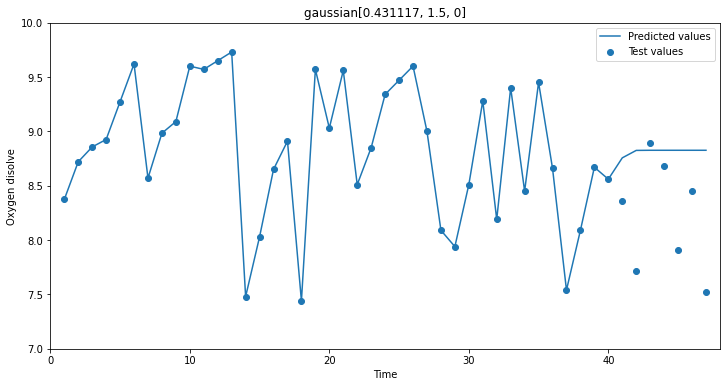

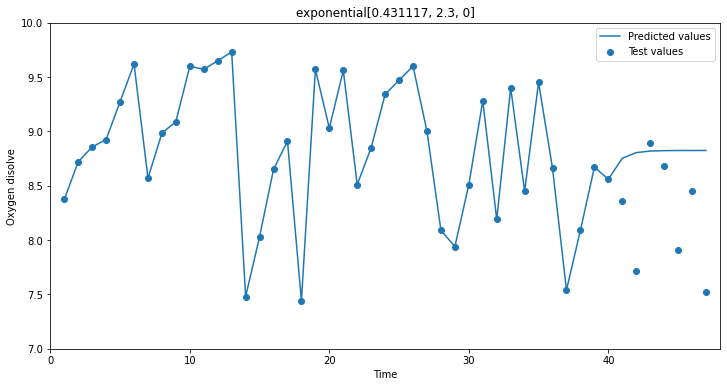

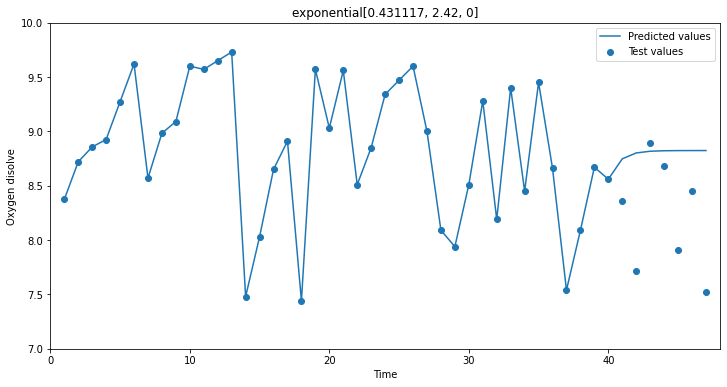

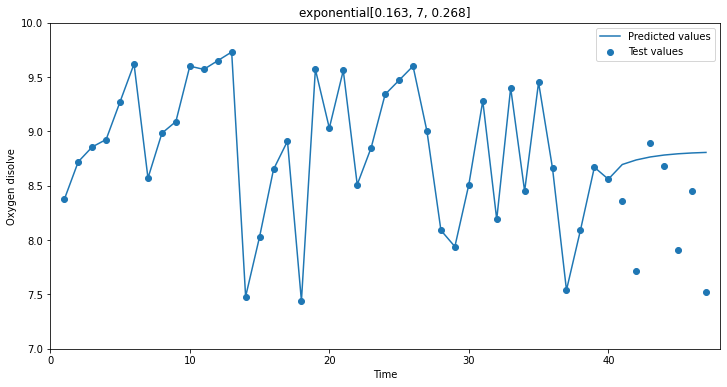

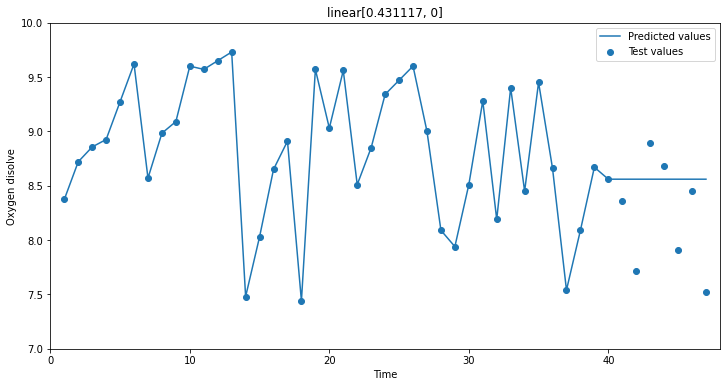

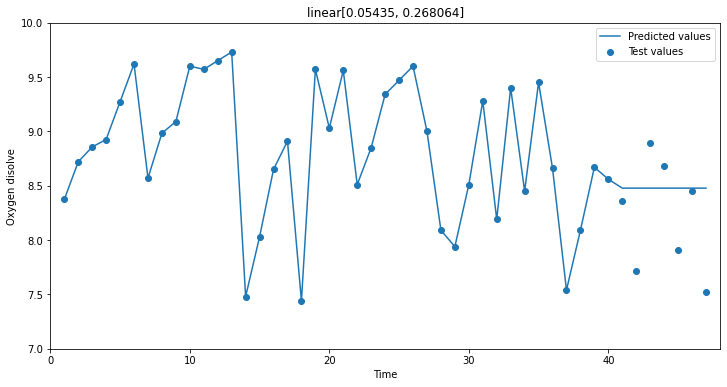

,"gaussian[0.431117, 1.5, 0]","exponential[0.431117, 2.3, 0]","exponential[0.431117, 2.42, 0]","exponential[0.163, 7, 0.268]","linear[0.431117, 0]","linear[0.05435, 0.268064]"
E,-0.5975,-0.5916,-0.5897,-0.5502,-0.3416,-0.2593
std,0.4771,0.4757,0.4758,0.4804,0.4737,0.4737
MAE,0.6157,0.6120,0.6106,0.5861,0.4701,0.4349
MSE,0.5846,0.5763,0.5742,0.5335,0.3410,0.2916


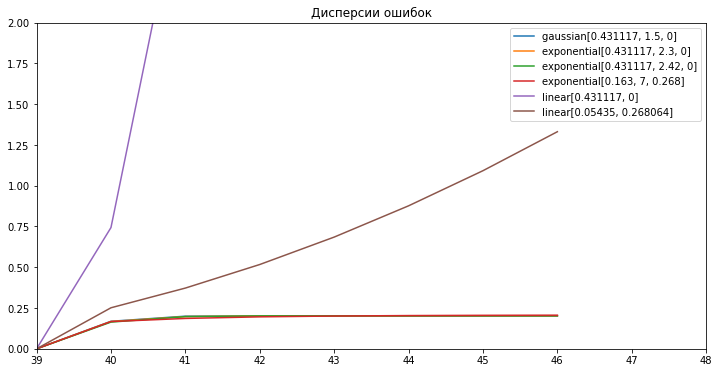

In [44]:
errors_table_kriging = []

def kriging(X_train, y_train, X_test, y_test, model_name, params):
    
    model = OrdinaryKriging(X_train, np.zeros(X_train.shape), y_train,
                     variogram_model=model_name,
                     variogram_parameters=params)
    
    y_pred, y_std = model.execute("grid", list(X_train) + list(X_test), np.array([0.0]))
    
    y_pred = np.squeeze(y_pred)
    y_std = np.squeeze(y_std)
    
    plot_kriging(list(X_train) + list(X_test), list(y_train) + list(y_test), y_pred, y_std, model_name + str(list(params.values())))
    errors_table_kriging.append(errors_table(model_name + str(list(params.values())), y_test, y_pred[len(y_train):]))
    return y_std**2, model_name + str(list(params.values()))
# Кригинг                             
variance_predicted_kriging = [kriging(*i) for i in kriging_models]
# Отрисовка дисперсий ошибок
fig, ax = plt.subplots(figsize=(12,6))
legends_var_kriging = []
for var in variance_predicted_kriging:
    ax.plot(var[0]);
    legends_var_kriging.append(var[1]);
ax.legend(legends_var_kriging);
ax.set_title('Дисперсии ошибок');
ax.set_xlim(39, 48)
ax.set_ylim(0, 2)

pd.concat(errors_table_kriging, axis=1).head()

                                       

### Выводы:
Если смотреть на таблицу, то лучшая модель будет линейная с самородком и на втором месте линейная без самородка. Однако если посомтреть на график Дисперсий ошибок, то они имеют наибольшие значения. Странно как то...

### Кросс валидация

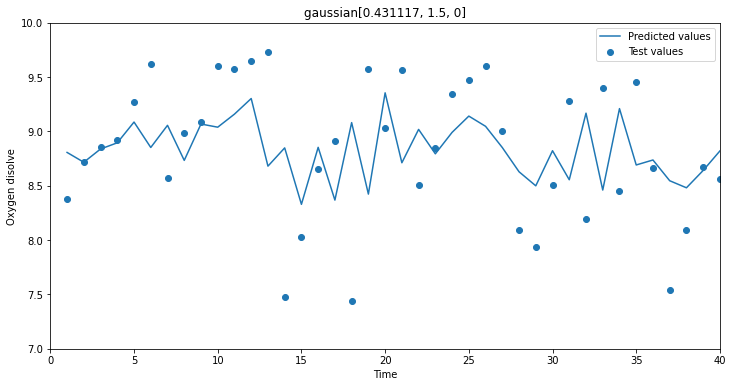

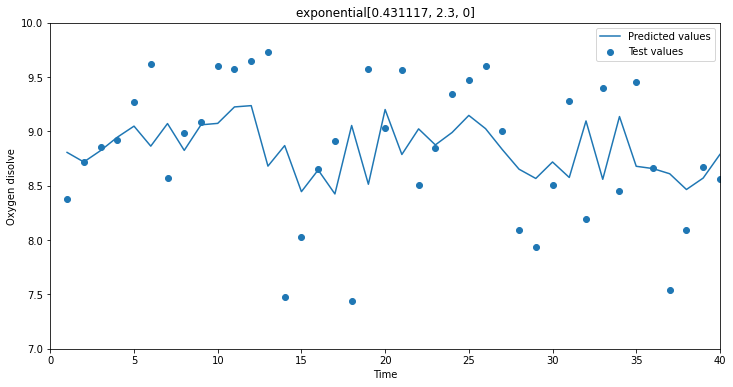

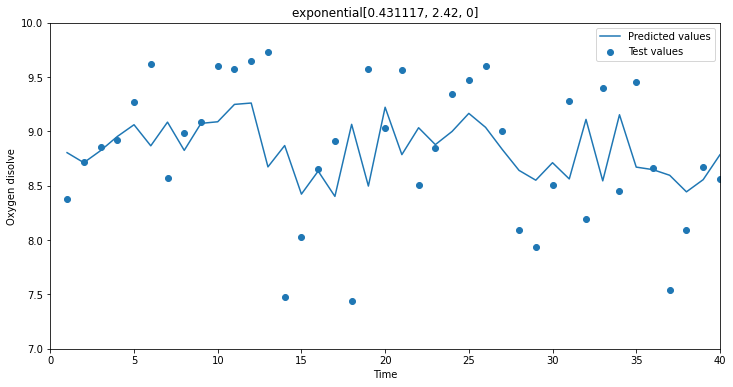

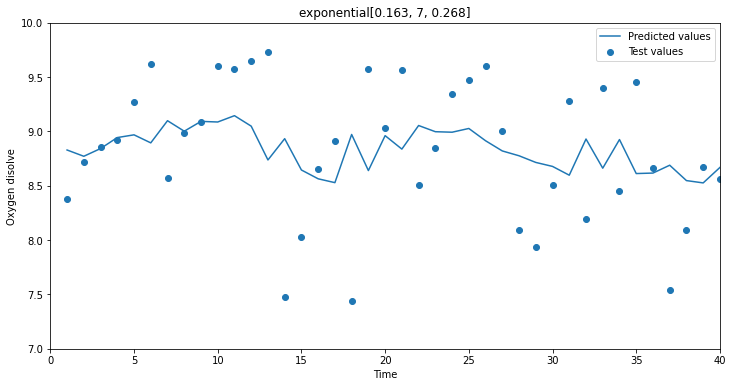

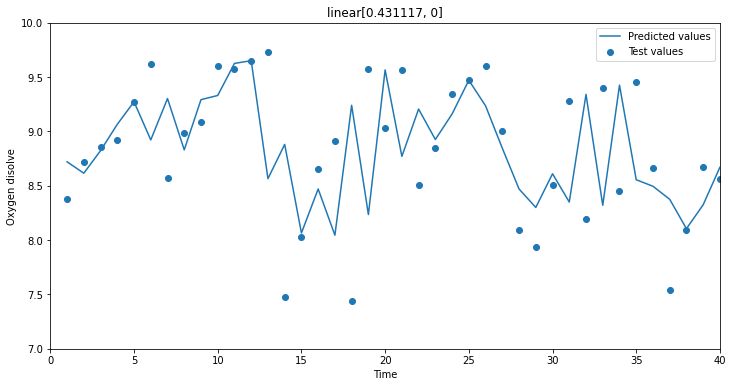

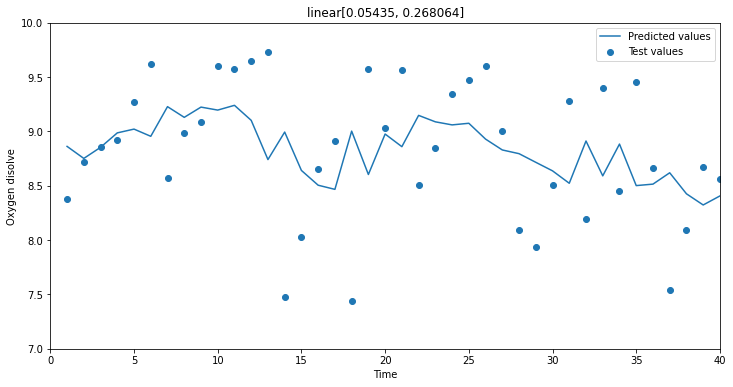

,"gaussian[0.431117, 1.5, 0]","exponential[0.431117, 2.3, 0]","exponential[0.431117, 2.42, 0]","exponential[0.163, 7, 0.268]","linear[0.431117, 0]","linear[0.05435, 0.268064]"
E,-0.0015,-0.0013,-0.0015,-0.0010,-0.0057,-0.0017
std,0.6369,0.6221,0.6232,0.6239,0.6758,0.6343
MAE,0.5056,0.4860,0.4857,0.4948,0.4913,0.5110
MSE,0.4056,0.3870,0.3884,0.3892,0.4568,0.4023


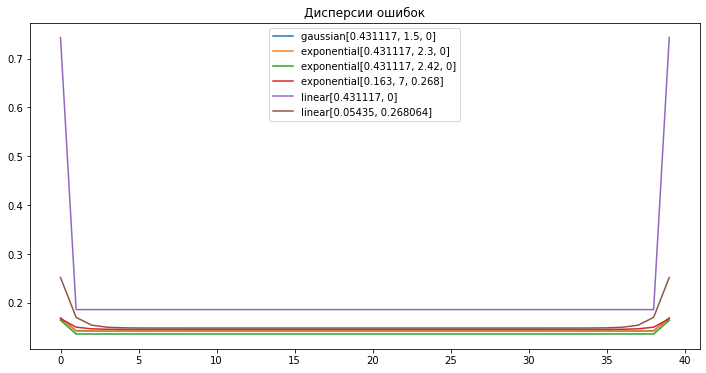

In [45]:
cr_table = []
def cross_validation(X_train, y_train, X_test, y_test, model_name, params):
    
    y_pred, y_std = [], []
    for i in range(len(X_train)):
        model = OrdinaryKriging(np.append(X_train[:i], X_train[i+1:]) , np.zeros(X_train.shape[0]-1), 
                     np.append(y_train[:i], y_train[i+1:]),
                     variogram_model=model_name,
                     variogram_parameters=params)
        pred, std = model.execute("grid", [i+1], np.array([0.0]))
        y_pred.append(pred)
        y_std.append(std)
        
    y_pred = np.squeeze(y_pred)
    y_std = np.squeeze(y_std)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.scatter(X_train, y_train, label="Test values")
    ax.plot(X_train, y_pred, label="Predicted values")
    ax.legend()
    ax.set_title(model_name + str(list(params.values())))
    ax.set_xlabel("Time")
    ax.set_ylabel("Oxygen disolve")
    ax.set_xlim(0, 40)
    ax.set_ylim(7, 10)
    plt.show()
    cr_table.append(errors_table(model_name + str(list(params.values())), y_train, y_pred))
    return y_std ** 2, model_name + str(list(params.values()))

#кригинг
kriging_variance_crossval = [cross_validation(*i) for i in kriging_models]
# отрисовка дисперсий ошибок
fig, ax = plt.subplots(figsize=(12,6))
legends_var_kriging = []
len(kriging_variance_crossval[0])
for var in kriging_variance_crossval:
    ax.plot(var[0]);
    legends_var_kriging.append(var[1]);
ax.legend(legends_var_kriging);
ax.set_title('Дисперсии ошибок');

# таблица ощибок
pd.concat(cr_table, axis=1).head()